<a href="https://colab.research.google.com/github/gopal2812/mlblr/blob/master/assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Sequential
from keras.datasets import cifar10
from keras.layers import AveragePooling2D, Input, Flatten
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import sys
import keras
import imutils

Using TensorFlow backend.


In [2]:
!pip install git+https://github.com/qubvel/classification_models.git
from classification_models.resnet import ResNet18, preprocess_input

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-36wm0i4v
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-36wm0i4v
  Running command git submodule update --init --recursive -q
  Stored in directory: /tmp/pip-ephem-wheel-cache-vdwcpbjl/wheels/de/2b/fd/29a6d33edb8c28bc7d94e95ea1d39c9a218ac500a3cfb1b197
Successfully built image-classifiers


In [3]:
n_classes=10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
nb_train_samples=x_train.__len__()
nb_valid_samples=x_test.__len__()

#Resizing Required
#x_train_resize = np.array([cv2.resize(img.transpose(1,2,0), (227,227)).transpose(2,0,1) for img in x_train[:nb_train_samples,:,:,:]])
#x_valid_resize = np.array([cv2.resize(img.transpose(1,2,0), (227,227)).transpose(2,0,1) for img in x_valid[:nb_valid_samples,:,:,:]])

170500096/170498071 [==============================] - 17s 0us/step


(128, 128, 3)


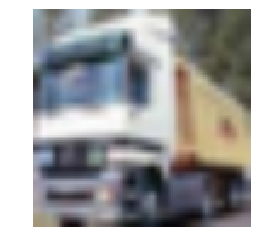

In [4]:
def display_image(img):
 img = cv2.resize(img,(128,128))
 print(img.shape)
 plt.imshow(img)
 plt.axis('off')
    
display_image(x_train[1])

In [5]:
# Input image dimensions.
input_shape = x_train.shape[1:]
x_test_orig = x_test
x_train_orig = x_train

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Do subtract pixel
x_train_mean = np.mean(x_train, axis=0)
x_train -= x_train_mean
x_test -= x_train_mean


print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train_orig=y_train
y_test_orig=y_test
y_train = keras.utils.to_categorical(y_train, n_classes)
y_test = keras.utils.to_categorical(y_test, n_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [7]:
image_model= ResNet18((32, 32, 3), include_top= False, weights='imagenet') 
#image_model.summary()
x = keras.layers.GlobalAveragePooling2D()(image_model.output)
output = keras.layers.Dense(n_classes, activation='softmax',name='predictions')(x)

model = keras.models.Model(input=image_model.input, outputs=[output])
model.summary()
model.compile(loss = "categorical_crossentropy", optimizer = keras.optimizers.SGD(), metrics=["accuracy"])

W0710 20:57:15.911788 140318458312576 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0710 20:57:15.962866 140318458312576 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0710 20:57:15.963994 140318458312576 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0710 20:57:15.965563 140318458312576 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0710 20:57:15.968297 140318

44924928/44920640 [==============================] - 5s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("da...)`
  
W0710 20:57:27.434099 140318458312576 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 32, 32, 3)    9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 38, 38, 3)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 16, 16, 64)   9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn0 (Batch

In [8]:
batch_size = 128
epochs = 30
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))


W0710 20:57:40.501142 140318458312576 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 22s 436us/step - loss: 1.1699 - acc: 0.5975 - val_loss: 0.8778 - val_acc: 0.7001
Epoch 2/30
50000/50000 [==============================] - 15s 294us/step - loss: 0.7144 - acc: 0.7514 - val_loss: 0.7640 - val_acc: 0.7378
Epoch 3/30
50000/50000 [==============================] - 15s 297us/step - loss: 0.5608 - acc: 0.8032 - val_loss: 0.7308 - val_acc: 0.7523
Epoch 4/30
50000/50000 [==============================] - 15s 300us/step - loss: 0.4461 - acc: 0.8455 - val_loss: 0.7111 - val_acc: 0.7630
Epoch 5/30
50000/50000 [==============================] - 15s 303us/step - loss: 0.3508 - acc: 0.8810 - val_loss: 0.7159 - val_acc: 0.7695
Epoch 6/30
50000/50000 [==============================] - 15s 304us/step - loss: 0.2713 - acc: 0.9101 - val_loss: 0.7275 - val_acc: 0.7738
Epoch 7/30
50000/50000 [==============================] - 15s 307us/step - loss: 0.2018 - acc: 0.9368 - val_loss: 0.

In [9]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 2s 199us/step
Test loss: 1.1691824247837066
Test accuracy: 0.7842


In [0]:
def convertCIFER10Data(image):
    img = image.astype('float32') / 255
    img = np.expand_dims(img, axis=0)
    return img

#i=convertCIFER10Data(x_test[1])
#print(i.shape)

1431


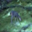

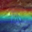

4675


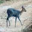

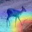

3229


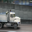

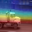

2240


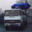

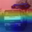

7145


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


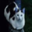

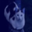

5842


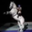

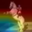

2162


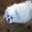

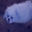

7680


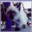

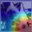

3135


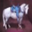

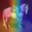

6378


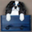

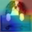

3047


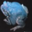

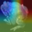

6673


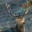

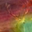

3449


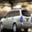

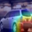

9461


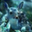

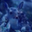

7788


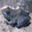

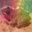

3815


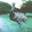

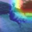

4907


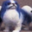

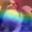

8138


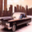

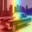

767


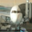

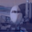

8604


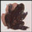

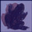

7917


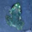

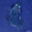

2634


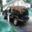

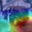

6493


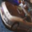

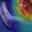

4512


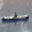

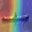

8048


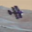

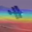

4521


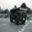

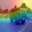

5408


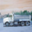

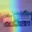

7128


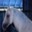

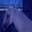

4299


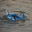

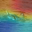

1444


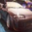

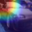

9928


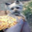

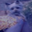

2066


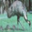

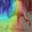

9865


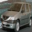

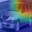

1772


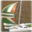

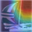

6559


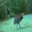

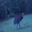

2383


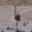

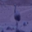

64 36


In [17]:
def show_image(val):
  right = 0
  mistake = 0
  for i in range(val):
    index = random.randint(0, x_test_orig.shape[0])
    image = x_test_orig[index]
    data = convertCIFER10Data(image)
    ret = model.predict(data, batch_size=1) 
    bestnum = 0.0
    bestclass = 0
    for n in [0,1,2,3,4,5,6,7,8,9]:
        if bestnum < ret[0][n]:
            bestnum = ret[0][n]
            bestclass = n
    #print(y_test_orig[index])
        

    if y_test_orig[index] == bestclass:
        right += 1
    else:
        print(index)
        class_output = model.output[:, bestclass]
        last_conv_layer = model.get_layer("stage3_unit2_conv1")
        grads = K.gradients(class_output, last_conv_layer.output)[0]
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
        iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
        
        pooled_grads_value, conv_layer_output_value = iterate([data])
        for i in range(256):
          conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
          
        heatmap = np.mean(conv_layer_output_value, axis=-1)
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)
        image =x_test_orig[index]
        heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        #print(image.shape, heatmap.shape)
        superimposed_img = cv2.addWeighted(image, 0.6, heatmap, 0.4, 0)
        #plt.figure(figsize=(32,32))
        #plt.subplot(10, 10, mistake+1)
        #plt.axis('off')
        #plt.imshow( image)
        #plt.imshow(superimposed_img)
        cv2_imshow(image)
        cv2_imshow(superimposed_img)
        cv2.waitKey(0)
        mistake += 1
  print(right,mistake)
  
show_image(100)
